In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('../data/0605_회전분류.csv')
df

,날짜,번호판,일일주행거리,누적주행거리,정보발생일시,차량속도,RPM,브레이크,GPS_X,GPS_Y,방위각,가속도_X,가속도_Y,회전max,회전min,회전max2,회전,위험운전회전
0,20221201,부산70자1854,0,66443,22120105071500,0,193,0,129.158670,35.236021,0,-6.3,0.7,46.548169,38.543643,54.552694,0,0
1,20221201,부산70자1854,0,66443,22120105071600,0,388,0,129.158670,35.236021,0,-7.9,1.6,46.548169,38.543643,54.552694,0,0
2,20221201,부산70자1854,0,66443,22120105071700,0,777,0,129.158670,35.236021,0,-8.9,2.2,46.548169,38.543643,54.552694,0,0
3,20221201,부산70자1854,0,66443,22120105071800,0,638,0,129.158670,35.236021,0,-6.6,0.8,46.548169,38.543643,54.552694,0,0
4,20221201,부산70자1854,0,66443,22120105071900,0,461,0,129.158670,35.236021,0,-7.1,0.8,46.548169,38.543643,54.552694,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5948207,20221231,부산70자1894,176,3095705,22123121033800,0,331,0,129.158597,35.235956,66,-5.7,-1.2,46.548169,38.543643,54.552694,0,0
5948208,20221231,부산70자1894,176,3095705,22123121033900,0,59,0,129.158597,35.235956,66,-5.8,-1.4,46.548169,38.543643,54.552694,0,0
5948209,20221231,부산70자1894,176,3095705,22123121034000,0,0,0,129.158597,35.235956,66,-5.4,-1.0,46.548169,38.543643,54.552694,0,0
5948210,20221231,부산70자1894,176,3095705,22123121034100,0,0,0,129.158597,35.235956,66,-5.4,-0.9,46.548169,38.543643,54.552694,0,0


In [3]:
df['년'] = df['정보발생일시'].apply(lambda x: int(str(x)[0:2]))
df['월'] = df['정보발생일시'].apply(lambda x: int(str(x)[2:4]))
df['일'] = df['정보발생일시'].apply(lambda x: int(str(x)[4:6]))
df['시'] = df['정보발생일시'].apply(lambda x: int(str(x)[6:8]))
df['분'] = df['정보발생일시'].apply(lambda x: int(str(x)[8:10]))
df['초'] = df['정보발생일시'].apply(lambda x: int(str(x)[10:12]))

In [4]:
df = df.query('번호판 != "부산70자1893"')

In [5]:
df.to_csv('../data/0608_회전분류.csv', index=False)

In [6]:
l = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.05, 0.1]
# l = [0.001, 0.003]
accuracy = []
f1 = []
drop = []

In [7]:
for i in l:
    df = pd.read_csv('../data/0608_회전분류.csv')
    acc0 = df.query('위험운전회전 == 0')
    X_train, X_test, y_train, y_test = train_test_split(acc0, acc0, random_state=42, shuffle=True, test_size=i)
    df = df.query('위험운전회전 != 0')
    drop.append(len(X_test.index))
    df = pd.concat([df, X_test], axis=0)
    X = df[['시', '분', 'GPS_X', 'GPS_Y']]
    y = df['위험운전회전']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.3)
    model = XGBClassifier(objective='multi:softmax', num_class=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_pred, y_test))
    f1.append(f1_score(y_pred, y_test, average='weighted'))

In [8]:
print(accuracy)
print(f1)
print(drop)

[0.8411647915287889, 0.7973159660548648, 0.7952563655388908, 0.7961233729485003, 0.7991193621325717, 0.8299159967482612, 0.8669334385391422, 0.9076754809238886, 0.9486043731983407, 0.9706887420101429]
[0.8642146648523816, 0.8144525035683345, 0.81009933267606, 0.8119743078963414, 0.8138295509579151, 0.8423033058694613, 0.8789625957917214, 0.917290665098337, 0.9586313733415686, 0.9792623235058329]
[445, 2224, 4448, 8896, 13344, 22239, 44478, 88955, 222387, 444773]


In [9]:
temp = pd.read_csv('../data/0608_회전분류.csv')
temp = temp.query('위험운전회전 != 0')
len(temp.index)

14663

In [10]:
d = list(map(lambda x: int(x / (len(temp.index) + x) * 100), drop))
d

[2, 13, 23, 37, 47, 60, 75, 85, 93, 96]

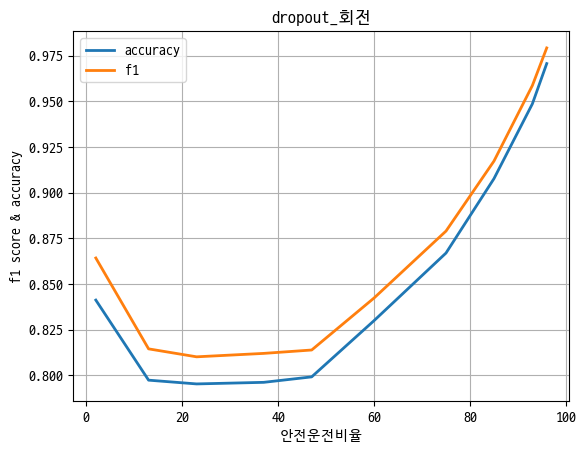

In [11]:
import matplotlib.pyplot as plt

plt.rc('font', family='D2Coding')
plt.title('dropout_회전')

plt.plot(d, accuracy, linewidth=2)
plt.plot(d, f1, linewidth=2)

plt.xlabel('안전운전비율')
plt.ylabel('f1 score & accuracy')

plt.grid(True)
plt.legend({'accuracy': accuracy, 'f1': f1})
plt.show()